In [1]:
import numpy as np
#This following is so that this will work with Latex, see
#http://bkanuka.com/articles/native-latex-plots/
import matplotlib as mpl
mpl.use('pgf')

In [2]:
def figsize(scale):                                 # I think scale is the size you want it on the page
    fig_width_pt = 433.62001                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.0                        # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_lualatex = {                      # Setup matplotlib to use latex for output
    "pgf.texsystem": "lualatex",           # Change this if using xetex or luatex
    "text.usetex": True,                   # Use LaTeX to write all text
    "pgf.rcfonts": False,
    #Fonts
    "font.family": "serif",                # Get from the pdf font function on the doc
    "font.serif": "Computer Modern Roman",      
    #"font.sans-serif": "Computer Modern Sans serif",
    #"font.serif": [],      
    "font.sans-serif": [],
    "font.monospace": [], # Blank entries should cause plots to inherit fonts from the document
    #Text size
    "font.size": 11,# Document default is 11pt font.
    #"text.fontsize": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    ##Axis
    #"axes.labelpad": 2,     # space between label and axis 
    "figure.figsize": figsize(1.0),     # default fig size of 1.0 textwidth
    #Packages
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        r"\usepackage{amsmath}",  #need to add math or the ^ won't work
        r"\usepackage{amssymb}"]
    }

mpl.rcParams.update(pgf_with_lualatex)

In [3]:
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from scipy.integrate import quad
from scipy.special import gamma

In [4]:
%matplotlib inline
pp.style.use('seaborn-ticks')
sns.set_palette("muted")

In [5]:
# Header for loading data
col_names = ['slug', 'wien', 'asym', 'asym_err', 'asym_n', 'precession', 'wien_state', 'ihwp']

In [6]:
# Load data
unreg_data = pd.read_csv('../database_extraction/data/al_unregressed.csv', header=None, names=col_names)
reg_data = pd.read_csv('../database_extraction/data/al_regressed.csv', header=None, names=col_names)
bb_data = pd.read_csv('data/al_bb_regressed.csv', header=None, names=col_names)
bb_correction_data = pd.read_csv('data/al_bb_correction.csv', header=None, names=col_names)
pol_data = pd.read_csv('data/al_pol_bb_regressed.csv', header=None, names=col_names)

In [7]:
bb_data.head()

,slug,wien,asym,asym_err,asym_n,precession,wien_state,ihwp
0,1028,6,-1.408384,0.295938,4460923,reverse,normal,out
1,1029,6,1.881821,0.370505,2795603,reverse,normal,in
2,1030,6,-1.563010,0.333136,3463500,reverse,normal,out
3,1031,6,1.684442,0.337515,3365150,reverse,normal,in
4,1032,6,-0.871967,0.524070,1398511,reverse,normal,out


In [8]:
def calc_chi2(fit, data, err, dof):
    chi2 = np.sum(np.square(data-fit)/np.square(err))
    return chi2, chi2/dof

def chi2probdistribution(chi2, dof):
    if chi2 > 0:
        num = np.power(chi2,(dof-2.0)/2.0)*np.exp(-chi2/2.0)
        dem = np.power(2.0,(dof/2.0))*gamma(dof/2.0)
        return num/dem
    elif chi2 == 0:
        return 0
    else:
        print('Chi^2 values < 0 not valid!')
        
def calc_chi2prob(chi2, dof):
    return quad(chi2probdistribution, chi2, np.inf, (dof))

In [9]:
def ihwp_plot(df, name, prelim=False):
    fig, slug_ax = pp.subplots(figsize=figsize(0.9), dpi=500)
    # Allow for Wien top axis
    wien_ax = slug_ax.twiny()

    slug_ax.set_xlim(1025, 1060)
    slug_ax.set_ylim(-3.0, 3.0)

    left_out = '(wien_state == "reverse") & ihwp == "out"'
    left_in = '(wien_state == "reverse") & ihwp == "in"'
    right_out = '(wien_state == "normal") & ihwp == "out"'
    right_in = '(wien_state == "normal") & ihwp == "in"'

    # Plot data versus slug number
    slug_ax.errorbar(df.query(left_out).slug, 
                     df.query(left_out).asym, 
                     yerr=df.query(left_out).asym_err, 
                     ls='None', 
                     marker='^',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull purple'], 
                     label='OUT$_{L}$')

    slug_ax.errorbar(df.query(left_in).slug, 
                     df.query(left_in).asym, 
                     yerr=df.query(left_in).asym_err, 
                     ls='None', 
                     marker='v',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull orange'], 
                     label='IN$_{L}$')

    slug_ax.errorbar(df.query(right_out).slug, 
                     df.query(right_out).asym, 
                     yerr=df.query(right_out).asym_err, 
                     ls='None', 
                     marker='s',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull red'], 
                     label='OUT$_{R}$')

    slug_ax.errorbar(df.query(right_in).slug, 
                     df.query(right_in).asym, 
                     yerr=df.query(right_in).asym_err, 
                     ls='None', 
                     marker='o',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull blue'], 
                     label='IN$_{R}$')

    # Calculate & Plot AVGs
    pos_avg, pos_sow = np.average(df[df['asym'] > 0].asym, 
                                  weights=1/np.square(df[df['asym'] > 0].asym_err), 
                                  returned=True)
    pos_dof = len(df[df['asym'] > 0].asym) - 1
    pos_chi2, pos_rchi2 = calc_chi2(pos_avg, df[df['asym'] > 0].asym, df[df['asym'] > 0].asym_err, pos_dof)
    pos_prob = calc_chi2prob(pos_chi2, pos_dof)
    slug_ax.plot(slug_ax.get_xlim(), 
                 [pos_avg, pos_avg], 
                 ls='-',
                 zorder=-10,
                 color=sns.xkcd_rgb['grey'])
    slug_ax.fill_between(slug_ax.get_xlim(), 
                         pos_avg+(1/np.sqrt(pos_sow)), 
                         pos_avg-(1/np.sqrt(pos_sow)), 
                         color=sns.xkcd_rgb['grey'], 
                         alpha=0.2)
    neg_avg, neg_sow = np.average(df[df['asym'] < 0].asym, 
                                  weights=1/np.square(df[df['asym'] < 0].asym_err), 
                                  returned=True)
    neg_dof = len(df[df['asym'] < 0].asym) - 1
    neg_chi2, neg_rchi2 = calc_chi2(neg_avg, df[df['asym'] < 0].asym, df[df['asym'] < 0].asym_err, neg_dof)
    neg_prob = calc_chi2prob(neg_chi2, neg_dof)
    slug_ax.plot(slug_ax.get_xlim(), 
                 [neg_avg, neg_avg], 
                 ls='-',
                 zorder=-10,
                 color=sns.xkcd_rgb['grey'])
    slug_ax.fill_between(slug_ax.get_xlim(), 
                         neg_avg+(1/np.sqrt(neg_sow)), 
                         neg_avg-(1/np.sqrt(neg_sow)), 
                         color=sns.xkcd_rgb['grey'], 
                         alpha=0.2)
    null_avg, null_sow = np.average([pos_avg, neg_avg], 
                                    weights=[pos_sow, neg_sow],
                                    returned=True)

    print('Positive Avg. {0:.5}+-{1:.5}     RChi2:{2:.5}     Prob:{3:.5}'.format(pos_avg, 
                                                                                 1/np.sqrt(pos_sow),
                                                                                 pos_rchi2,
                                                                                 pos_prob[0]))
    print('Negative Avg. {0:.5}+-{1:.5}     RChi2:{2:.5}     Prob:{3:.5}'.format(neg_avg,
                                                                                 1/np.sqrt(neg_sow),
                                                                                 neg_rchi2,
                                                                                 neg_prob[0]))
    print('Null {0:.5}+-{1:.5}'.format((pos_avg+neg_avg)/2, 1/np.sqrt(null_sow)))


    # Labels for slug plot axes
    slug_ax.set_xlabel('Time (Slug)')
    slug_ax.set_ylabel('Asymmetry [ppm]')
    # Increase number of minor ticks
    slug_minorlocator = AutoMinorLocator(5)
    asym_minorlocator = AutoMinorLocator(4)
    slug_ax.xaxis.set_minor_locator(slug_minorlocator)
    slug_ax.yaxis.set_minor_locator(asym_minorlocator)
    # Configure Wien "top" axis
    wien_ax.xaxis.set_ticks_position('top')
    wien_ax.xaxis.set_label_position('top')
    wien_ax.set_frame_on(True)
    wien_ax.set_visible(True)
    wien_ax.spines['left'].set_visible(False)
    wien_ax.spines['right'].set_visible(False)
    wien_ax.spines['bottom'].set_visible(False)
    slug_ax.spines['top'].set_visible(False)
    wien_ax.spines['top'].set_visible(True)
    # Set Wien axis limits
    wien_ax.set_xlim(slug_ax.get_xlim())
    # Set Wien axis major tick locations
    wien_major_pos = [1027.5, 1032.5, 1043.5, 1058.5]
    wien_ax.set_xticks(wien_major_pos)
    wien_ax.set_xticklabels('')
    # Set Wien axis minor tick locations with labels
    wien_ax.set_xticks([1030, 1038, 1051], minor=True)
    wien_ax.set_xticklabels(['(g-2 flip)\n 6', '8', '9'], minor=True)
    # Zero length to Wien axis minor ticks
    wien_ax.tick_params(which='minor', length=0)
    # Allow grid for Wien axis major ticks
    wien_ax.grid(True, which='major')
    wien_ax.set_xlabel('Time (Wien)')
    # Legend
    slug_ax.legend(bbox_to_anchor=(1.2, 1))
    # Preliminary Tag
    if prelim == True:
        pp.text(1042.5, 
                0.0, 
                'Preliminary', 
                fontsize=72, 
                rotation=31.717, 
                verticalalignment='center', 
                horizontalalignment='center', 
                color=sns.xkcd_rgb['dark grey'], 
                alpha=0.2)
    # Save Plots
    pp.savefig('plots/' + name + '_ihwp.eps', bbox_inches='tight')
    pp.savefig('plots/' + name + '_ihwp.png', bbox_inches='tight')
    pp.savefig('plots/' + name + '_ihwp.pdf', bbox_inches='tight')
    pp.savefig('plots/' + name + '_ihwp.pgf', bbox_inches='tight')
    return

In [10]:
def sign_corrected_plot(df, name, prelim=False):
    fig, slug_ax = pp.subplots(figsize=figsize(0.9))
    # Allow for Wien top axis
    wien_ax = slug_ax.twiny()

    slug_ax.set_xlim(1025, 1060)
    slug_ax.set_ylim(0.0, 3.0)

    left_out = '(wien_state == "reverse") & ihwp == "out"'
    left_in = '(wien_state == "reverse") & ihwp == "in"'
    right_out = '(precession == "normal" & wien_state == "normal") & ihwp == "out"'
    right_in = '(precession == "normal" & wien_state == "normal") & ihwp == "in"'
    right_out_g2 = '(precession == "reverse" & wien_state == "normal") & ihwp == "out"'
    right_in_g2 = '(precession == "reverse" & wien_state == "normal") & ihwp == "in"'

    # Plot data versus slug number
    slug_ax.errorbar(df.query(left_out).slug, 
                     -1.0*df.query(left_out).asym, 
                     yerr=df.query(left_out).asym_err, 
                     ls='None', 
                     marker='^',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull purple'], 
                     label='OUT$_{L}$')

    slug_ax.errorbar(df.query(left_in).slug, 
                     df.query(left_in).asym, 
                     yerr=df.query(left_in).asym_err, 
                     ls='None', 
                     marker='v',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull orange'], 
                     label='IN$_{L}$')

    slug_ax.errorbar(df.query(right_out).slug, 
                     df.query(right_out).asym, 
                     yerr=df.query(right_out).asym_err, 
                     ls='None', 
                     marker='s',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull red'], 
                     label='OUT$_{R}$')

    slug_ax.errorbar(df.query(right_in).slug, 
                     -1.0*df.query(right_in).asym, 
                     yerr=df.query(right_in).asym_err, 
                     ls='None', 
                     marker='o',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull blue'], 
                     label='IN$_{R}$')
    
    slug_ax.errorbar(df.query(right_out_g2).slug, 
                     -1.0*df.query(right_out_g2).asym, 
                     yerr=df.query(right_out_g2).asym_err, 
                     ls='None', 
                     marker='s',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull red'], label=None)
    
    slug_ax.errorbar(df.query(right_in_g2).slug, 
                     df.query(right_in_g2).asym, 
                     yerr=df.query(right_in_g2).asym_err, 
                     ls='None', 
                     marker='o',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull blue'], label=None)

    # Calculate & Plot AVGs
    sign_corrected_asym = np.concatenate([df[df['asym'] > 0].asym, -1.0*df[df['asym'] < 0].asym])
    sign_corrected_asym_err = np.concatenate([df[df['asym'] > 0].asym_err, df[df['asym'] < 0].asym_err])
    avg, sow = np.average(sign_corrected_asym, 
                          weights=1/np.square(sign_corrected_asym_err), 
                          returned=True)
    sc_dof = len(sign_corrected_asym) - 1
    sc_chi2, sc_rchi2 = calc_chi2(avg, sign_corrected_asym, sign_corrected_asym_err, sc_dof)
    sc_prob = calc_chi2prob(sc_chi2, sc_dof)
    slug_ax.plot(slug_ax.get_xlim(), 
                 [avg, avg], 
                 ls='-',
                 zorder=-10,
                 color=sns.xkcd_rgb['grey'])
    slug_ax.fill_between(slug_ax.get_xlim(), 
                         avg+(1/np.sqrt(sow)), 
                         avg-(1/np.sqrt(sow)), 
                         color=sns.xkcd_rgb['grey'], 
                         alpha=0.2)

    print('Avg. {0:.6}+-{1:.5}     Chi2:{2:.5}     Prob:{3:.5}'.format(avg, 
                                                                       1/np.sqrt(sow),
                                                                       sc_rchi2,
                                                                       sc_prob[0]))

    # Labels for slug plot axes
    slug_ax.set_xlabel('Time (Slug)')
    slug_ax.set_ylabel('Asymmetry [ppm]')
    # Increase number of minor ticks
    slug_minorlocator = AutoMinorLocator(5)
    asym_minorlocator = AutoMinorLocator(4)
    slug_ax.xaxis.set_minor_locator(slug_minorlocator)
    slug_ax.yaxis.set_minor_locator(asym_minorlocator)
    # Configure Wien "top" axis
    wien_ax.xaxis.set_ticks_position('top')
    wien_ax.xaxis.set_label_position('top')
    wien_ax.set_frame_on(True)
    wien_ax.set_visible(True)
    wien_ax.spines['left'].set_visible(False)
    wien_ax.spines['right'].set_visible(False)
    wien_ax.spines['bottom'].set_visible(False)
    slug_ax.spines['top'].set_visible(False)
    wien_ax.spines['top'].set_visible(True)
    # Set Wien axis limits
    wien_ax.set_xlim(slug_ax.get_xlim())
    # Set Wien axis major tick locations
    wien_major_pos = [1027.5, 1032.5, 1043.5, 1058.5]
    wien_ax.set_xticks(wien_major_pos)
    wien_ax.set_xticklabels('')
    # Set Wien axis minor tick locations with labels
    wien_ax.set_xticks([1030, 1038, 1051], minor=True)
    wien_ax.set_xticklabels(['(g-2 flip)\n 6', '8', '9'], minor=True)
    # Zero length to Wien axis minor ticks
    wien_ax.tick_params(which='minor', length=0)
    # Allow grid for Wien axis major ticks
    wien_ax.grid(True, which='major')
    wien_ax.set_xlabel('Time (Wien)')
    # Legend
    slug_ax.legend(bbox_to_anchor=(1.2, 1))
    # Preliminary Tag
    if prelim == True:
        pp.text(1042.5, 
                1.5, 
                'Preliminary', 
                fontsize=72, 
                rotation=31.717, 
                verticalalignment='center', 
                horizontalalignment='center', 
                color=sns.xkcd_rgb['dark grey'], 
                alpha=0.2)
    # Save Plots
    pp.savefig('plots/' + name + '_sign_corrected.png', bbox_inches='tight')
    pp.savefig('plots/' + name + '_sign_corrected.pdf', bbox_inches='tight')
    pp.savefig('plots/' + name + '_sign_corrected.pgf', bbox_inches='tight')
    return

Positive Avg. 1.4796+-0.099055     RChi2:1.6153     Prob:0.07295
Negative Avg. -1.4069+-0.092954     RChi2:1.2587     Prob:0.22452
Null 0.036375+-0.067782


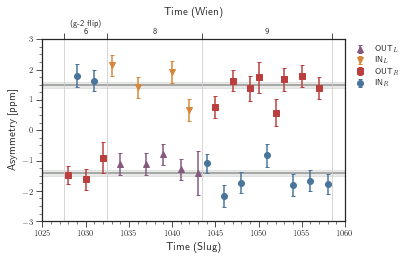

In [35]:
ihwp_plot(unreg_data, 'al_unregressed', False)

Avg. 1.44095+-0.067782     Chi2:1.3896     Prob:0.082411


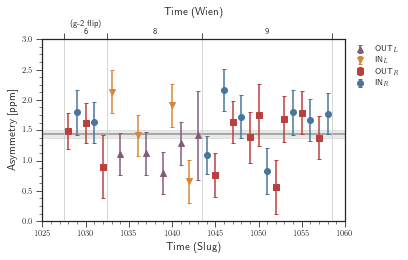

In [36]:
sign_corrected_plot(unreg_data, 'al_unregressed', False)

Positive Avg. 1.4693+-0.099011     RChi2:1.6288     Prob:0.069543
Negative Avg. -1.4168+-0.092909     RChi2:1.2692     Prob:0.21749
Null 0.026251+-0.067751


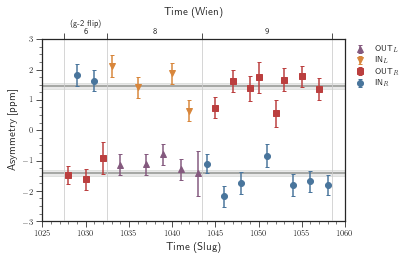

In [37]:
ihwp_plot(reg_data, 'al_regressed', False)

Avg. 1.44136+-0.067751     Chi2:1.3962     Prob:0.079429


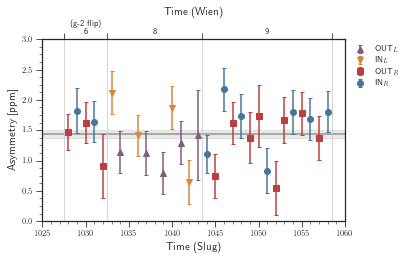

In [38]:
sign_corrected_plot(reg_data, 'al_regressed', False)

Positive Avg. 1.4388+-0.099014     RChi2:1.7125     Prob:0.051426
Negative Avg. -1.4349+-0.092911     RChi2:1.1137     Prob:0.33897
Null 0.0019626+-0.067753


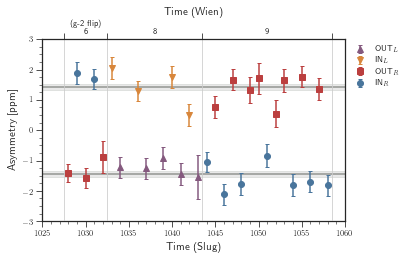

In [45]:
ihwp_plot(bb_data, 'al_bb', False)

Avg. 1.43671+-0.067753     Chi2:1.3519     Prob:0.10118


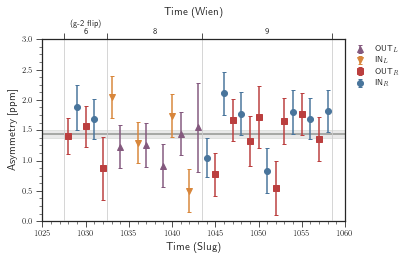

In [46]:
sign_corrected_plot(bb_data, 'al_bb', False)

Positive Avg. 1.6199+-0.11158     RChi2:1.7409     Prob:0.046317
Negative Avg. -1.6161+-0.10471     RChi2:1.1339     Prob:0.32112
Null 0.0019105+-0.076353


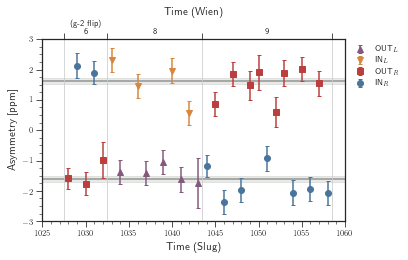

In [47]:
ihwp_plot(pol_data, 'al_pol', False)

Avg. 1.61791+-0.076353     Chi2:1.3752     Prob:0.089198


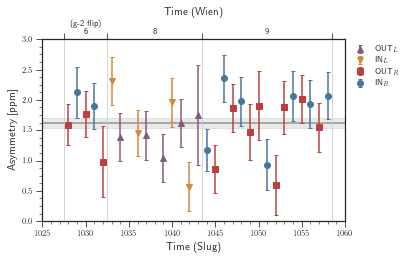

In [48]:
sign_corrected_plot(pol_data, 'al_pol', False)

In [12]:
def bb_correction_plot(df, name, prelim=False):
    fig, slug_ax = pp.subplots(figsize=figsize(0.9))
    # Allow for Wien top axis
    wien_ax = slug_ax.twiny()

    slug_ax.set_xlim(1025, 1060)
    slug_ax.set_ylim(-160.0, 80.0)

    left_out = '(wien_state == "reverse") & ihwp == "out"'
    left_in = '(wien_state == "reverse") & ihwp == "in"'
    right_out = '(precession == "normal" & wien_state == "normal") & ihwp == "out"'
    right_in = '(precession == "normal" & wien_state == "normal") & ihwp == "in"'
    right_out_g2 = '(precession == "reverse" & wien_state == "normal") & ihwp == "out"'
    right_in_g2 = '(precession == "reverse" & wien_state == "normal") & ihwp == "in"'

    # Plot data versus slug number
    slug_ax.errorbar(df.query(left_out).slug, 
                     df.query(left_out).asym, 
                     yerr=df.query(left_out).asym_err, 
                     ls='None', 
                     marker='^',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull purple'], 
                     label='OUT$_{L}$')

    slug_ax.errorbar(df.query(left_in).slug, 
                     df.query(left_in).asym, 
                     yerr=df.query(left_in).asym_err, 
                     ls='None', 
                     marker='v',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull orange'], 
                     label='IN$_{L}$')

    slug_ax.errorbar(df.query(right_out).slug, 
                     df.query(right_out).asym, 
                     yerr=df.query(right_out).asym_err, 
                     ls='None', 
                     marker='s',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull red'], 
                     label='OUT$_{R}$')

    slug_ax.errorbar(df.query(right_in).slug, 
                     df.query(right_in).asym, 
                     yerr=df.query(right_in).asym_err, 
                     ls='None', 
                     marker='o',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull blue'], 
                     label='IN$_{R}$')
    
    slug_ax.errorbar(df.query(right_out_g2).slug, 
                     df.query(right_out_g2).asym, 
                     yerr=df.query(right_out_g2).asym_err, 
                     ls='None', 
                     marker='s',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull red'], label=None)
    
    slug_ax.errorbar(df.query(right_in_g2).slug, 
                     df.query(right_in_g2).asym, 
                     yerr=df.query(right_in_g2).asym_err, 
                     ls='None', 
                     marker='o',
                     capsize=2.0,
                     capthick=1.0,
                     barsabove=True,
                     color=sns.xkcd_rgb['dull blue'], label=None)

    # Calculate & Plot AVGs
    #sign_corrected_asym = np.concatenate([df[df['asym'] > 0].asym, -1.0*df[df['asym'] < 0].asym])
    #sign_corrected_asym_err = np.concatenate([df[df['asym'] > 0].asym_err, df[df['asym'] < 0].asym_err])
    #avg, sow = np.average(sign_corrected_asym, 
    #                      weights=1/np.square(sign_corrected_asym_err), 
    #                      returned=True)
    #sc_dof = len(sign_corrected_asym) - 1
    #sc_chi2, sc_rchi2 = calc_chi2(avg, sign_corrected_asym, sign_corrected_asym_err, sc_dof)
    #sc_prob = calc_chi2prob(sc_chi2, sc_dof)
    #slug_ax.plot(slug_ax.get_xlim(), 
    #             [avg, avg], 
    #             ls='-',
    #             zorder=-10,
    #             color=sns.xkcd_rgb['grey'])
    #slug_ax.fill_between(slug_ax.get_xlim(), 
    #                     avg+(1/np.sqrt(sow)), 
    #                     avg-(1/np.sqrt(sow)), 
    #                     color=sns.xkcd_rgb['grey'], 
    #                     alpha=0.2)

    #print('Avg. {0:.6}+-{1:.5}     Chi2:{2:.5}     Prob:{3:.5}'.format(avg, 
    #                                                                   1/np.sqrt(sow),
    #                                                                   sc_rchi2,
    #                                                                   sc_prob[0]))

    # Labels for slug plot axes
    slug_ax.set_xlabel('Time (Slug)')
    slug_ax.set_ylabel('Correction Size [ppb]')
    # Increase number of minor ticks
    slug_minorlocator = AutoMinorLocator(5)
    asym_minorlocator = AutoMinorLocator(4)
    slug_ax.xaxis.set_minor_locator(slug_minorlocator)
    slug_ax.yaxis.set_minor_locator(asym_minorlocator)
    # Configure Wien "top" axis
    wien_ax.xaxis.set_ticks_position('top')
    wien_ax.xaxis.set_label_position('top')
    wien_ax.set_frame_on(True)
    wien_ax.set_visible(True)
    wien_ax.spines['left'].set_visible(False)
    wien_ax.spines['right'].set_visible(False)
    wien_ax.spines['bottom'].set_visible(False)
    slug_ax.spines['top'].set_visible(False)
    wien_ax.spines['top'].set_visible(True)
    # Set Wien axis limits
    wien_ax.set_xlim(slug_ax.get_xlim())
    # Set Wien axis major tick locations
    wien_major_pos = [1027.5, 1032.5, 1043.5, 1058.5]
    wien_ax.set_xticks(wien_major_pos)
    wien_ax.set_xticklabels('')
    # Set Wien axis minor tick locations with labels
    wien_ax.set_xticks([1030, 1038, 1051], minor=True)
    wien_ax.set_xticklabels(['(g-2 flip)\n 6', '8', '9'], minor=True)
    # Zero length to Wien axis minor ticks
    wien_ax.tick_params(which='minor', length=0)
    # Allow grid for Wien axis major ticks
    wien_ax.grid(True, which='major')
    wien_ax.set_xlabel('Time (Wien)')
    # Legend
    slug_ax.legend(bbox_to_anchor=(1.2, 1))
    # Preliminary Tag
    if prelim == True:
        pp.text(1042.5, 
                1.5, 
                'Preliminary', 
                fontsize=72, 
                rotation=31.717, 
                verticalalignment='center', 
                horizontalalignment='center', 
                color=sns.xkcd_rgb['dark grey'], 
                alpha=0.2)
    # Save Plots
    pp.savefig('plots/' + name + '.png', bbox_inches='tight')
    pp.savefig('plots/' + name + '.pdf', bbox_inches='tight')
    pp.savefig('plots/' + name + '.pgf', bbox_inches='tight')
    return

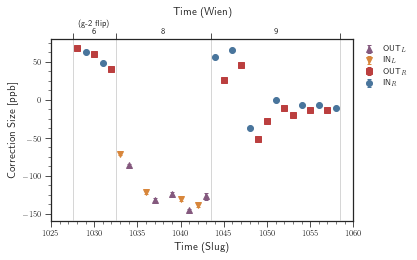

In [13]:
bb_correction_plot(bb_correction_data, 'al_bb_correction', False)